Az alábbi file-ban kisebb modellekkel próbálkozunk, valamint ezeknek a modelleknek a paramétereit változtatgatni hogy megnézzük ki lehet-e hozni olyan teljesítményt mint a nagyobb modellel kevesebb erőforrás árán.

In [1]:
import os

input_dir = "./oxford-iiit-pet/images/"
target_dir = "./oxford-iiit-pet/annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
./oxford-iiit-pet/images/Abyssinian_1.jpg | ./oxford-iiit-pet/annotations/trimaps/Abyssinian_1.png
./oxford-iiit-pet/images/Abyssinian_10.jpg | ./oxford-iiit-pet/annotations/trimaps/Abyssinian_10.png
./oxford-iiit-pet/images/Abyssinian_100.jpg | ./oxford-iiit-pet/annotations/trimaps/Abyssinian_100.png
./oxford-iiit-pet/images/Abyssinian_101.jpg | ./oxford-iiit-pet/annotations/trimaps/Abyssinian_101.png
./oxford-iiit-pet/images/Abyssinian_102.jpg | ./oxford-iiit-pet/annotations/trimaps/Abyssinian_102.png
./oxford-iiit-pet/images/Abyssinian_103.jpg | ./oxford-iiit-pet/annotations/trimaps/Abyssinian_103.png
./oxford-iiit-pet/images/Abyssinian_104.jpg | ./oxford-iiit-pet/annotations/trimaps/Abyssinian_104.png
./oxford-iiit-pet/images/Abyssinian_105.jpg | ./oxford-iiit-pet/annotations/trimaps/Abyssinian_105.png
./oxford-iiit-pet/images/Abyssinian_106.jpg | ./oxford-iiit-pet/annotations/trimaps/Abyssinian_106.png
./oxford-iiit-pet/images/Abyssinian_107.jpg | ./oxford-

Előfeldolgozatlan képek beolvasása

In [ ]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(batch_size, img_size, input_img_paths, target_img_paths, max_dataset_len=None):

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        target_img -= 1
        return input_img, target_img

    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

Egy kisebb U-net architektúra felépítése

In [3]:
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for filters in [16, 32]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [32, 16, 8]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    #Classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)


    model = keras.Model(inputs, outputs)
    
    return model


model = get_model(img_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 80, 80,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 80, 80,    │        816 │ activation_1[0][… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 80, 80,    │        416 │ activation_2[0][… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 40,    │        528 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 40, 40,    │          0 │ add[0][0]         │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 40, 40,    │        688 │ activation_3[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 35,315 (137.95 KB)

 Trainable params: 34,835 (136.07 KB)

 Non-trainable params: 480 (1.88 KB)

Látható hogy a paraméterk számokis jelentősen lecsökkentek

In [4]:
import random

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]


train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [5]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

epochs = 50
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/50
32/32 - 28s - 884ms/step - loss: 2.7447 - val_loss: 2.7062
Epoch 2/50
32/32 - 14s - 448ms/step - loss: 1.6143 - val_loss: 1.6582
Epoch 3/50
32/32 - 14s - 442ms/step - loss: 1.3255 - val_loss: 1.3721
Epoch 4/50
32/32 - 15s - 462ms/step - loss: 1.1744 - val_loss: 1.1617
Epoch 5/50
32/32 - 13s - 409ms/step - loss: 1.0750 - val_loss: 1.0430
Epoch 6/50
32/32 - 14s - 447ms/step - loss: 1.0043 - val_loss: 1.0153
Epoch 7/50
32/32 - 14s - 432ms/step - loss: 0.9517 - val_loss: 1.0498
Epoch 8/50
32/32 - 13s - 413ms/step - loss: 0.9115 - val_loss: 1.0988
Epoch 9/50
32/32 - 13s - 414ms/step - loss: 0.8796 - val_loss: 1.1217
Epoch 10/50
32/32 - 13s - 407ms/step - loss: 0.8537 - val_loss: 1.1004
Epoch 11/50
32/32 - 13s - 414ms/step - loss: 0.8322 - val_loss: 1.0410
Epoch 12/50
32/32 - 13s - 414ms/step - loss: 0.8140 - val_loss: 0.9632
Epoch 13/50
32/32 - 13s - 413ms/step - loss: 0.7983 - val_loss: 0.8920
Epoch 14/50
32/32 - 13s - 415ms/step - loss: 0.7845 - val_loss: 0.8351
Epoch 15/50
32/

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step


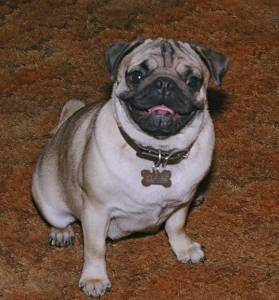

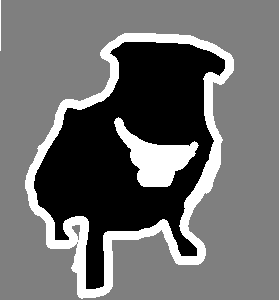

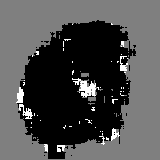

In [ ]:
from PIL import ImageOps
from keras.utils import load_img
from IPython.display import Image, display


def pred(model):
    val_dataset = get_dataset(
        batch_size, img_size, val_input_img_paths, val_target_img_paths
    )
    val_preds = model.predict(val_dataset)


    def display_mask(i):
        """Quick utility to display a model's prediction."""
        mask = np.argmax(val_preds[i], axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
        display(img)


    # validation image #10
    i = 10

    display(Image(filename=val_input_img_paths[i]))

    img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
    display(img)

    display_mask(i)  
    
pred(model)

A tesztből látható, hogy a kutya formáját nagyjából eltalálta, azonban a kontürje teljesen elvesződik a szimplább modell felépítése miatt.

Következőnek megnézzük 1e-3 alpha értékkel a traininget ugyanezzel a modellel.

Epoch 1/50
32/32 - 28s - 870ms/step - loss: 1.0739 - val_loss: 1.0152
Epoch 2/50
32/32 - 15s - 472ms/step - loss: 0.7638 - val_loss: 0.9847
Epoch 3/50
32/32 - 15s - 459ms/step - loss: 0.7129 - val_loss: 1.1538
Epoch 4/50
32/32 - 15s - 467ms/step - loss: 0.6845 - val_loss: 1.3617
Epoch 5/50
32/32 - 14s - 452ms/step - loss: 0.6627 - val_loss: 1.6150
Epoch 6/50
32/32 - 16s - 504ms/step - loss: 0.6445 - val_loss: 1.8057
Epoch 7/50
32/32 - 15s - 456ms/step - loss: 0.6303 - val_loss: 1.8398
Epoch 8/50
32/32 - 14s - 448ms/step - loss: 0.6159 - val_loss: 1.8504
Epoch 9/50
32/32 - 14s - 439ms/step - loss: 0.6009 - val_loss: 1.8087
Epoch 10/50
32/32 - 14s - 447ms/step - loss: 0.5877 - val_loss: 1.5989
Epoch 11/50
32/32 - 14s - 443ms/step - loss: 0.5757 - val_loss: 1.3862
Epoch 12/50
32/32 - 14s - 451ms/step - loss: 0.5651 - val_loss: 1.0839
Epoch 13/50
32/32 - 15s - 472ms/step - loss: 0.5553 - val_loss: 0.9428
Epoch 14/50
32/32 - 14s - 444ms/step - loss: 0.5468 - val_loss: 0.8438
Epoch 15/50
32/

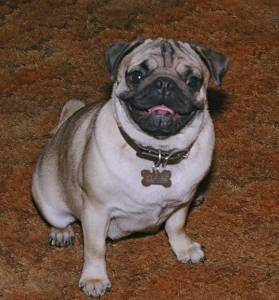

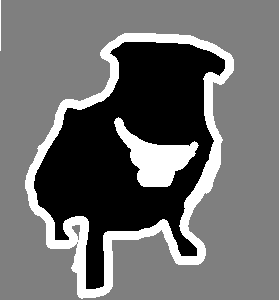

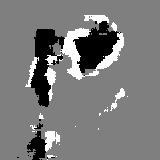

In [7]:
model2 = get_model(img_size, num_classes)

model2.compile(
    optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

epochs = 50
model2.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

pred(model2)

Látható, hogy a modell így már kevesebbett tudott konvergálni és nem tudta megfelelően optimalizálni a gradiensét a magas lépésszám (alpha) miatt.

Következő teszt: megnézzük 1e-5 alphával hátha az segít.

Epoch 1/50
32/32 - 26s - 804ms/step - loss: 2.6137 - val_loss: 3.3298
Epoch 2/50
32/32 - 14s - 448ms/step - loss: 2.3803 - val_loss: 1.8972
Epoch 3/50
32/32 - 15s - 459ms/step - loss: 2.2067 - val_loss: 1.5675
Epoch 4/50
32/32 - 14s - 430ms/step - loss: 2.0693 - val_loss: 1.5766
Epoch 5/50
32/32 - 12s - 388ms/step - loss: 1.9531 - val_loss: 1.6767
Epoch 6/50
32/32 - 12s - 386ms/step - loss: 1.8518 - val_loss: 1.7686
Epoch 7/50
32/32 - 12s - 385ms/step - loss: 1.7629 - val_loss: 1.8174
Epoch 8/50
32/32 - 12s - 387ms/step - loss: 1.6848 - val_loss: 1.8158
Epoch 9/50
32/32 - 12s - 388ms/step - loss: 1.6162 - val_loss: 1.7680
Epoch 10/50
32/32 - 12s - 384ms/step - loss: 1.5557 - val_loss: 1.6841
Epoch 11/50
32/32 - 12s - 386ms/step - loss: 1.5025 - val_loss: 1.5799
Epoch 12/50
32/32 - 13s - 395ms/step - loss: 1.4552 - val_loss: 1.4747
Epoch 13/50
32/32 - 15s - 457ms/step - loss: 1.4130 - val_loss: 1.3859
Epoch 14/50
32/32 - 15s - 454ms/step - loss: 1.3752 - val_loss: 1.3207
Epoch 15/50
32/

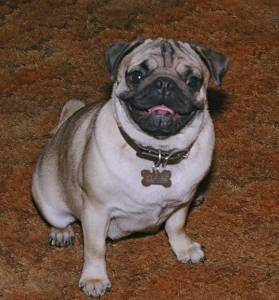

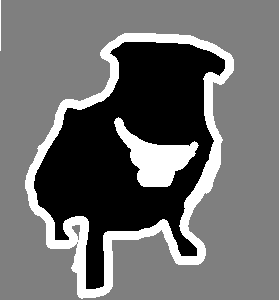

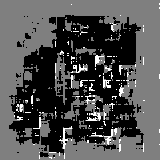

In [8]:
model3 = get_model(img_size, num_classes)

model3.compile(
    optimizer=keras.optimizers.Adam(1e-5), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

epochs = 50
model3.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

pred(model3)

Az eredmény mégrosszabb, a modell 50 epoch alatt nagyon keveset tanult a kisebb alpha érték miatt, így az 1e-4 optimálisan bizonyul

Következő lépésben megnézzük has epochig képezzük a modell-t milyen eredményt hoz

Epoch 1/25
32/32 - 30s - 939ms/step - loss: 2.0140 - val_loss: 1.9212
Epoch 2/25
32/32 - 17s - 545ms/step - loss: 1.2675 - val_loss: 1.2071
Epoch 3/25
32/32 - 17s - 532ms/step - loss: 1.0805 - val_loss: 1.0594
Epoch 4/25
32/32 - 15s - 474ms/step - loss: 0.9921 - val_loss: 1.0257
Epoch 5/25
32/32 - 14s - 437ms/step - loss: 0.9338 - val_loss: 1.0378
Epoch 6/25
32/32 - 14s - 439ms/step - loss: 0.8903 - val_loss: 1.0694
Epoch 7/25
32/32 - 14s - 438ms/step - loss: 0.8548 - val_loss: 1.1036
Epoch 8/25
32/32 - 14s - 441ms/step - loss: 0.8250 - val_loss: 1.1279
Epoch 9/25
32/32 - 14s - 443ms/step - loss: 0.8002 - val_loss: 1.1304
Epoch 10/25
32/32 - 14s - 437ms/step - loss: 0.7795 - val_loss: 1.1019
Epoch 11/25
32/32 - 14s - 439ms/step - loss: 0.7621 - val_loss: 1.0392
Epoch 12/25
32/32 - 15s - 472ms/step - loss: 0.7472 - val_loss: 0.9607
Epoch 13/25
32/32 - 15s - 477ms/step - loss: 0.7342 - val_loss: 0.8801
Epoch 14/25
32/32 - 14s - 433ms/step - loss: 0.7228 - val_loss: 0.8109
Epoch 15/25
32/

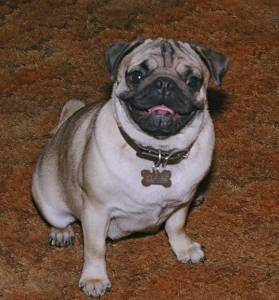

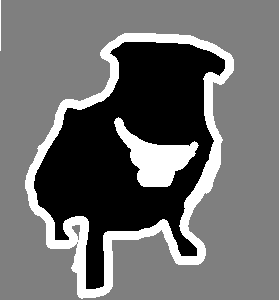

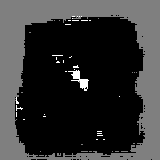

In [9]:
model4 = get_model(img_size, num_classes)

model4.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

epochs = 25
model4.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

pred(model4)

Látható, hogy kevés epoch alatt keveset tud tanulni a modell és közel sem tanulta meg megfelelően szegmentálni az adatot,

Megpróbáltam az adatot categorical_Crossentropy-val is trainelni loss-ként viszont az adatok alakja miatt ez nem lehetséges

In [10]:
model5 = get_model(img_size, num_classes)

model5.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

epochs = 100
model5.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

pred(model5)

Epoch 1/100


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 160, 160, 1), output.shape=(None, 160, 160, 3)

Következő tesztként, nézzük mennyit tanul a modell ha csak 10 epochig traineljük

Epoch 1/10
32/32 - 25s - 782ms/step - loss: 1.7353 - val_loss: 1.7283
Epoch 2/10
32/32 - 15s - 483ms/step - loss: 1.1504 - val_loss: 1.2565
Epoch 3/10
32/32 - 14s - 435ms/step - loss: 0.9929 - val_loss: 1.0797
Epoch 4/10
32/32 - 13s - 407ms/step - loss: 0.9167 - val_loss: 0.9979
Epoch 5/10
32/32 - 13s - 413ms/step - loss: 0.8685 - val_loss: 0.9532
Epoch 6/10
32/32 - 13s - 415ms/step - loss: 0.8347 - val_loss: 0.9264
Epoch 7/10
32/32 - 13s - 412ms/step - loss: 0.8095 - val_loss: 0.9082
Epoch 8/10
32/32 - 15s - 456ms/step - loss: 0.7897 - val_loss: 0.8914
Epoch 9/10
32/32 - 15s - 471ms/step - loss: 0.7735 - val_loss: 0.8723
Epoch 10/10
32/32 - 15s - 475ms/step - loss: 0.7597 - val_loss: 0.8513
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step


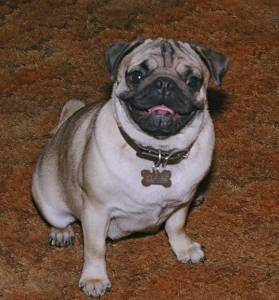

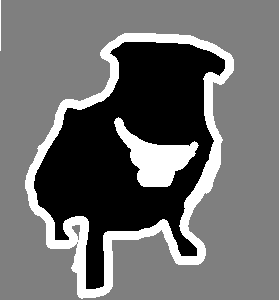

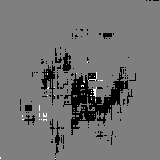

In [11]:
model6 = get_model(img_size, num_classes)

model6.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

epochs = 10
model6.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

pred(model6)

Látható hogy próbálkozik, viszont szinte semmit nem tanult a modellünk

Végső tesztként, vágjuk le a downsampling rétegeit, és hagyjuk meg teljes méretében az upsampling részét

In [12]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for filters in [32, 64]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [64, 32, 16]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    #Classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)


    model = keras.Model(inputs, outputs)
    
    return model


model7 = get_model(img_size, num_classes)
model7.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 80, 80,    │        896 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_67       │ (None, 80, 80,    │          0 │ activation_66[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_24 │ (None, 80, 80,    │      1,344 │ activation_67[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 40, 40,    │      1,056 │ activation_66[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 40, 40,    │          0 │ max_pooling2d_12… │
│                     │ 32)               │            │ conv2d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_68       │ (None, 40, 40,    │          0 │ add_30[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_25 │ (None, 40, 40,    │      2,400 │ activation_68[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 20, 20,    │      2,112 │ add_30[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_31 (Add)        │ (None, 20, 20,    │          0 │ max_pooling2d_13… │
│                     │ 64)               │            │ conv2d_44[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_69       │ (None, 20, 20,    │          0 │ add_31[0][0]    

 Total params: 75,987 (296.82 KB)

 Trainable params: 75,507 (294.95 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/50
32/32 - 53s - 2s/step - loss: 2.1486 - val_loss: 4.1013
Epoch 2/50
32/32 - 20s - 639ms/step - loss: 1.1034 - val_loss: 1.8118
Epoch 3/50
32/32 - 19s - 588ms/step - loss: 0.9603 - val_loss: 1.1889
Epoch 4/50
32/32 - 19s - 588ms/step - loss: 0.8950 - val_loss: 1.0582
Epoch 5/50
32/32 - 20s - 632ms/step - loss: 0.8537 - val_loss: 1.0545
Epoch 6/50
32/32 - 22s - 681ms/step - loss: 0.8240 - val_loss: 1.0666
Epoch 7/50
32/32 - 19s - 598ms/step - loss: 0.8011 - val_loss: 1.0605
Epoch 8/50
32/32 - 24s - 759ms/step - loss: 0.7827 - val_loss: 1.0311
Epoch 9/50
32/32 - 19s - 585ms/step - loss: 0.7674 - val_loss: 0.9853
Epoch 10/50
32/32 - 19s - 599ms/step - loss: 0.7545 - val_loss: 0.9324
Epoch 11/50
32/32 - 19s - 591ms/step - loss: 0.7432 - val_loss: 0.8784
Epoch 12/50
32/32 - 20s - 623ms/step - loss: 0.7334 - val_loss: 0.8288
Epoch 13/50
32/32 - 18s - 569ms/step - loss: 0.7246 - val_loss: 0.7877
Epoch 14/50
32/32 - 19s - 579ms/step - loss: 0.7166 - val_loss: 0.7577
Epoch 15/50
32/32 

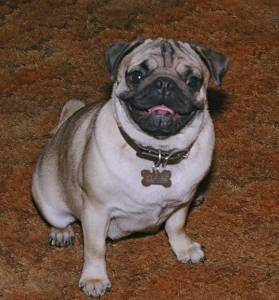

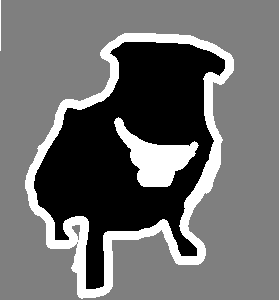

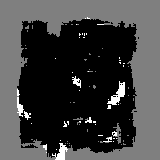

In [13]:
model7 = get_model(img_size, num_classes)

model7.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

epochs = 50
model7.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

pred(model7)

Látható, hogy ez sem segít a szegmentálásban, így konklúzióként elmondható, hogy egy ilyen komplikált feladatnál, szükségesek a hosszú és paraméterdús konvolúciós hálókra.